In [1]:
!pip install -q tensorflow==2.0.0-beta1

tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 2.0.0b1 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install -q statsmodels==0.9.0

tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 2.0.0b1 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install -q scipy==1.2

tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 2.0.0b1 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!pip install -q pyramid.arima

tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 2.0.0b1 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import os
import csv
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler

In [6]:
import boto3 
import botocore 
import pandas as pd 
from sagemaker import get_execution_role 

role = get_execution_role() 

bucket = 'enter_bucket' 
data_key = 'enter_data_key'
data_location = 's3://{}/{}'.format(bucket, data_key) 

df = pd.read_csv(data_location)

In [7]:
from pandas import DataFrame

In [8]:
tseries=df['Price']
tseries

0       18.63
1       18.45
2       18.55
3       18.60
4       18.63
5       18.60
6       18.60
7       18.58
8       18.65
9       18.68
10      18.75
11      18.78
12      18.65
13      18.75
14      18.78
15      18.78
16      18.68
17      18.78
18      18.90
19      19.03
20      19.05
21      19.05
22      19.10
23      18.90
24      18.75
25      18.70
26      19.08
27      19.15
28      19.08
29      18.98
        ...  
8186    59.03
8187    60.60
8188    59.81
8189    58.64
8190    58.64
8191    58.44
8192    60.42
8193    60.59
8194    61.04
8195    58.55
8196    57.93
8197    60.68
8198    62.70
8199    61.28
8200    63.99
8201    64.67
8202    63.02
8203    60.76
8204    61.25
8205    68.42
8206    65.59
8207    64.29
8208    64.25
8209    65.23
8210    64.66
8211    64.13
8212    62.41
8213    62.08
8214    62.48
8215    60.99
Name: Price, Length: 8216, dtype: float64

In [9]:
tseries = tseries[:7716]

In [10]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(tseries)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.862846
p-value: 0.349736
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [11]:
tsdiff=np.log(tseries)

In [12]:
result = adfuller(tsdiff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.570385
p-value: 0.498451
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


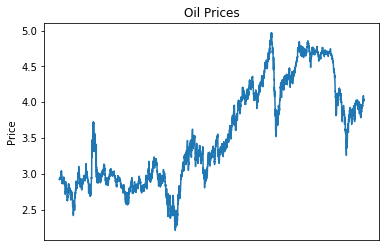

In [13]:
import matplotlib.pyplot as plt
plt.plot(tsdiff)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Price')
plt.title("Oil Prices")
plt.show()

In [14]:
df=pd.DataFrame(tsdiff)
df

,Price
0,2.924773
1,2.915064
2,2.920470
3,2.923162
4,2.924773
5,2.923162
6,2.923162
7,2.922086
8,2.925846
9,2.927453


In [15]:
# Form dataset matrix
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
df=np.array(df)

In [17]:
df

array([[2.92477318],
       [2.91506437],
       [2.92046979],
       ...,
       [4.01638302],
       [4.01259206],
       [4.03636228]])

In [18]:
# normalize dataset with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)
df

array([[0.25948897],
       [0.2559728 ],
       [0.25793044],
       ...,
       [0.6548291 ],
       [0.65345615],
       [0.66206484]])

In [19]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Training and Validation data partition
train_size = int(len(df) * 0.8)
val_size = len(df) - train_size
train, val = df[0:train_size,:], df[train_size:len(df),:]

# Number of previous
previous = 500
X_train, Y_train = create_dataset(train, previous)
X_val, Y_val = create_dataset(val, previous)

In [20]:
X_train

array([[0.25948897, 0.2559728 , 0.25793044, ..., 0.26945914, 0.26431659,
        0.2797141 ],
       [0.2559728 , 0.25793044, 0.25890531, ..., 0.26431659, 0.2797141 ,
        0.27415651],
       [0.25793044, 0.25890531, 0.25948897, ..., 0.2797141 , 0.27415651,
        0.26277874],
       ...,
       [0.72183662, 0.71670258, 0.7347286 , ..., 0.91004565, 0.92053555,
        0.92331339],
       [0.71670258, 0.7347286 , 0.7376476 , ..., 0.92053555, 0.92331339,
        0.92315789],
       [0.7347286 , 0.7376476 , 0.73347036, ..., 0.92331339, 0.92315789,
        0.92156802]])

In [21]:
Y_train

array([0.27415651, 0.26277874, 0.26718257, ..., 0.92315789, 0.92156802,
       0.91325661])

Train on 4536 samples, validate on 1135 samples
Epoch 1/60
4536/4536 - 8s - loss: 0.0060 - val_loss: 0.1066
Epoch 2/60
4536/4536 - 7s - loss: 0.0035 - val_loss: 0.0205
Epoch 3/60
4536/4536 - 8s - loss: 0.0028 - val_loss: 0.0269
Epoch 4/60
4536/4536 - 7s - loss: 0.0022 - val_loss: 0.0228
Epoch 5/60
4536/4536 - 7s - loss: 0.0029 - val_loss: 0.0205
Epoch 6/60
4536/4536 - 7s - loss: 0.0021 - val_loss: 0.0162
Epoch 7/60
4536/4536 - 7s - loss: 0.0022 - val_loss: 0.0305
Epoch 8/60
4536/4536 - 7s - loss: 0.0025 - val_loss: 0.0301
Epoch 9/60
4536/4536 - 7s - loss: 0.0019 - val_loss: 0.0381
Epoch 10/60
4536/4536 - 7s - loss: 0.0019 - val_loss: 0.0319
Epoch 11/60
4536/4536 - 7s - loss: 0.0017 - val_loss: 0.0192
Epoch 12/60
4536/4536 - 7s - loss: 0.0019 - val_loss: 0.0218
Epoch 13/60
4536/4536 - 7s - loss: 0.0019 - val_loss: 0.0235
Epoch 14/60
4536/4536 - 7s - loss: 0.0018 - val_loss: 0.0276
Epoch 15/60
4536/4536 - 7s - loss: 0.0015 - val_loss: 0.0180
Epoch 16/60
4536/4536 - 7s - loss: 0.0017 - va

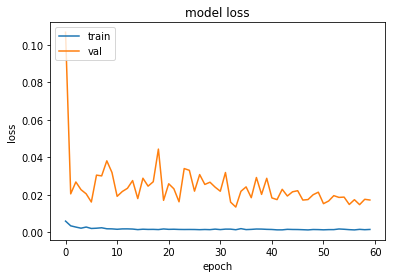

In [22]:
from tensorflow.keras.layers import Dropout

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

# Generate LSTM network
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1, previous)))
model.add(Dropout(0.05))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, Y_train, validation_split=0.2, epochs=60, batch_size=1, verbose=2)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
# Generate predictions
trainpred = model.predict(X_train)
valpred = model.predict(X_val)

In [24]:
trainpred

array([[0.2910921 ],
       [0.28821778],
       [0.28221902],
       ...,
       [0.7273096 ],
       [0.7275281 ],
       [0.72764546]], dtype=float32)

In [25]:
valpred

array([[0.72966623],
       [0.72969365],
       [0.7296136 ],
       ...,
       [0.6634985 ],
       [0.6633887 ],
       [0.6631737 ]], dtype=float32)

In [26]:
# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
valpred = scaler.inverse_transform(valpred)
Y_val = scaler.inverse_transform([Y_val])
predictions = valpred

In [27]:
import math
from sklearn.metrics import mean_squared_error

# calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_val[0], valpred[:,0]))
print('Validation Score: %.2f RMSE' % (valScore))

Train Score: 0.17 RMSE
Validation Score: 0.25 RMSE


In [28]:
# Train predictions
trainpredPlot = np.empty_like(df)
trainpredPlot[:, :] = np.nan
trainpredPlot[previous:len(trainpred)+previous, :] = trainpred

In [29]:
# Validation predictions
valpredPlot = np.empty_like(df)
valpredPlot[:, :] = np.nan
valpredPlot[len(trainpred)+(previous*2)+1:len(df)-1, :] = valpred

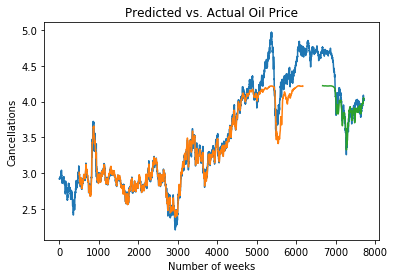

In [30]:
# Plot all predictions
inversetransform, =plt.plot(scaler.inverse_transform(df))
trainpred, =plt.plot(trainpredPlot)
valpred, =plt.plot(valpredPlot)
plt.xlabel('Number of weeks')
plt.ylabel('Cancellations')
plt.title("Predicted vs. Actual Oil Price")
plt.show()

In [31]:
Y_val=Y_val.reshape(-1)
Y_val.shape
Y_val=pd.Series(Y_val)

In [32]:
Y_val

0       4.746670
1       4.719391
2       4.721797
3       4.728361
4       4.730127
5       4.708268
6       4.691806
7       4.692173
8       4.706462
9       4.702478
10      4.687303
11      4.679164
12      4.695559
13      4.690063
14      4.695468
15      4.680741
16      4.675815
17      4.692173
18      4.695833
19      4.695194
20      4.697385
21      4.705558
22      4.691531
23      4.715190
24      4.706372
25      4.701661
26      4.706553
27      4.707637
28      4.696381
29      4.695011
          ...   
1013    3.944297
1014    3.949511
1015    3.964426
1016    3.973118
1017    3.962716
1018    3.982109
1019    3.997834
1020    3.991943
1021    3.999118
1022    3.992681
1023    4.008423
1024    4.016743
1025    4.038832
1026    4.028561
1027    4.016383
1028    4.035656
1029    4.046554
1030    4.055777
1031    4.063198
1032    4.084631
1033    4.090504
1034    4.073121
1035    4.074142
1036    4.043402
1037    4.019441
1038    4.027492
1039    4.025352
1040    4.0446

In [33]:
predictions=predictions.reshape(-1)
predictions.shape
predictions=pd.Series(predictions)

In [34]:
predictions

0       4.223023
1       4.223098
2       4.222877
3       4.222795
4       4.222641
5       4.222510
6       4.222241
7       4.221884
8       4.221684
9       4.221754
10      4.221670
11      4.221398
12      4.221074
13      4.221072
14      4.221067
15      4.221234
16      4.221011
17      4.220814
18      4.220881
19      4.220837
20      4.220808
21      4.220785
22      4.220966
23      4.220830
24      4.221096
25      4.221198
26      4.221205
27      4.221270
28      4.221285
29      4.221168
          ...   
1013    3.977386
1014    3.977300
1015    3.973960
1016    3.972486
1017    3.975514
1018    3.976624
1019    3.977893
1020    3.978896
1021    3.977070
1022    3.971652
1023    3.969912
1024    3.969378
1025    3.971554
1026    3.977367
1027    3.983540
1028    3.989477
1029    3.995872
1030    4.004705
1031    4.013029
1032    4.022136
1033    4.031398
1034    4.040120
1035    4.046838
1036    4.052641
1037    4.053326
1038    4.048864
1039    4.044345
1040    4.0403

In [35]:
import numpy as np

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [36]:
mda(Y_val, predictions)

0.9980824544582934

In [37]:
# https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/

from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(Y_val, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.248797


In [38]:
forecast_error = (predictions-Y_val)
forecast_error

0      -0.523647
1      -0.496293
2      -0.498920
3      -0.505566
4      -0.507487
5      -0.485758
6      -0.469565
7      -0.470289
8      -0.484778
9      -0.480725
10     -0.465633
11     -0.457766
12     -0.474485
13     -0.468991
14     -0.474400
15     -0.459508
16     -0.454804
17     -0.471359
18     -0.474952
19     -0.474357
20     -0.476577
21     -0.484773
22     -0.470565
23     -0.494359
24     -0.485276
25     -0.480464
26     -0.485348
27     -0.486366
28     -0.475096
29     -0.473843
          ...   
1013    0.033089
1014    0.027789
1015    0.009534
1016   -0.000632
1017    0.012798
1018   -0.005485
1019   -0.019941
1020   -0.013046
1021   -0.022048
1022   -0.021029
1023   -0.038511
1024   -0.047365
1025   -0.067278
1026   -0.051194
1027   -0.032843
1028   -0.046179
1029   -0.050682
1030   -0.051072
1031   -0.050169
1032   -0.062495
1033   -0.059106
1034   -0.033001
1035   -0.027304
1036    0.009239
1037    0.033884
1038    0.021372
1039    0.018994
1040   -0.0043

In [39]:
mean_forecast_error = np.mean(forecast_error)
mean_forecast_error

-0.15253456969682347

In [40]:
# Predict last 10 days of oil prices using t-500
Xnew = np.array([[58.74,
58.8,
57.02,
55.67,
56.12,
56,
57.09,
55.5,
55.29,
56.62,
56.13,
56.13,
56.86,
57.49,
57.63,
58.05,
57.82,
57.89,
57.69,
57.84,
58.45,
58.75,
60.15,
60.65,
61.35,
60.98,
60.79,
61.42,
64.27,
64.36,
63.96,
64.49,
64.35,
62.94,
60.91,
61.25,
61.18,
61.34,
61.34,
62.28,
62.92,
63.27,
63.58,
63.25,
63.56,
63.74,
63.53,
64.57,
63.45,
63.45,
62.25,
62.37,
63.86,
65.62,
64.96,
63.66,
63.72,
63.81,
64.45,
63.69,
64.43,
64.64,
64.61,
66.03,
66.8,
66.73,
66.65,
67.85,
68.73,
68.01,
68.48,
69.08,
69.79,
70.36,
69.64,
70.31,
69.4,
69.19,
69.48,
68.56,
69.32,
69.81,
69.91,
71.08,
70.08,
68.41,
67.78,
67.78,
68.6,
67.45,
67.69,
66.75,
65.74,
64.26,
63.04,
62.2,
61.94,
62.29,
62.86,
64.3,
64.95,
64.68,
64.81,
66.12,
67.04,
67.96,
67.59,
66.08,
64.23,
64.26,
65.78,
65.67,
65.09,
63.87,
65.19,
64.53,
64.2,
63.61,
63.67,
64.68,
64.82,
66,
68.15,
68.98,
69.03,
68.81,
68.63,
68.13,
69.02,
69.02,
66.04,
66.54,
66.51,
68.19,
70.67,
72.74,
71.44,
73.18,
72.05,
71.71,
73.73,
74.85,
74.62,
74.54,
75.86,
73.79,
75.39,
75.33,
75.92,
74.85,
73.14,
73.45,
74.75,
74.16,
77.6,
77.59,
77.37,
78.17,
78.94,
78.19,
80.09,
78.38,
78.34,
80.42,
78.69,
78.9,
76.6,
74.51,
75.89,
76.45,
74.54,
73.41,
72.91,
73.23,
75.23,
75.11,
74.58,
74.86,
75.07,
74.77,
72.02,
74.87,
74.92,
74.25,
72.87,
73.67,
72.82,
73.58,
76.09,
76.26,
77.44,
76.71,
75.87,
76.99,
77.09,
74.98,
77.08,
77.8,
75.35,
72.11,
74.11,
71.03,
70.87,
70.52,
71.94,
71.99,
73.45,
73.53,
73.67,
74.51,
74.84,
74.99,
74.16,
72.28,
72.95,
72.48,
72.51,
72.31,
70.71,
70.55,
71,
70.62,
70.77,
68.38,
69.21,
70.14,
71.11,
71.65,
72.96,
73.73,
74.41,
74.41,
75.91,
76.07,
77.05,
76.94,
77.81,
77.51,
76.68,
75.67,
75.55,
76.77,
78.22,
80.02,
77.66,
77.87,
78.22,
79.25,
79.43,
79.03,
78.9,
80.89,
82.21,
81.87,
81.54,
82.72,
84.94,
85.63,
85.45,
86.07,
85.12,
84.22,
85.16,
83.82,
81.35,
80.71,
80.91,
80.53,
79.91,
80.3,
80.38,
80.45,
78.67,
77.34,
77.3,
77.4,
77.56,
75.68,
74.84,
71.25,
71.11,
72.68,
70.64,
70.1,
69.29,
69.01,
69.81,
65.45,
64.88,
65.61,
65.29,
64.14,
61.5,
61.65,
61.11,
57.69,
59.7,
59.58,
57.97,
58.29,
57.71,
60.17,
61.22,
61.4,
57.83,
61.71,
60.29,
59.73,
59.94,
59.03,
58.56,
57.59,
55.26,
55.6,
52.84,
51.93,
51.49,
50.57,
54.06,
53.23,
55.64,
57.1,
56.91,
59.46,
60.47,
59.24,
58.8,
58.65,
59.81,
59.85,
62.04,
62.18,
60.9,
61.05,
61.09,
61.49,
59.71,
60.98,
61.89,
62.46,
61.86,
62.26,
61.67,
62.22,
61.01,
61.37,
61.3,
62.58,
63.27,
64,
65.65,
66.41,
65.86,
66.82,
66.91,
66.91,
64.02,
64.51,
65.55,
65.03,
63.71,
64.44,
64.24,
64.51,
64.82,
65.66,
65.06,
65.33,
65.89,
66.18,
66.11,
66.65,
67.13,
68.35,
68.3,
66.29,
67.37,
67.51,
67.35,
66.08,
67.93,
69.08,
69.68,
69.21,
69.8,
69.93,
71.12,
71.02,
71.63,
71.3,
71.57,
70.9,
70.74,
71.14,
70.71,
70.71,
74.39,
73.59,
74.94,
71.03,
71.22,
72.19,
72.01,
70.56,
71.95,
71.95,
70.98,
71.09,
70.61,
71.63,
72.35,
72.53,
73.09,
74.7,
73.94,
73.21,
72.94,
71.94,
68.37,
67.98,
70.19,
70.64,
69.55,
66.78,
63.16,
63.56,
62.14,
62.77,
64.1,
64.31,
63.56,
61.66,
63.28,
63.13,
62.56,
63.35,
62.85,
65.44,
65.99,
65.16,
66.24,
66.85,
66.78,
67.52,
65.1,
62.72,
63.53,
63.62,
64.23,
64.89,
64.3,
66.41,
67.64,
66.65,
66.86,
65.87,
63.67,
60.7,
61.04,
61.96,
62.28,
63.83,
63.47,
62.46,
62.29,
62.55,
64.07,
62.9,
61.12,
59.32,
58.63,
55.03,
56.29,
57.37,
57.13,
59.9,
57.86,
57.37,
59,
59.79,
59.03,
60.6,
59.81,
58.64,
58.64,
58.44,
60.42,
60.59,
61.04,
58.55,
57.93,
60.68,
62.7,
61.28,
63.99,
64.67,
63.02,
60.76,
61.25,
68.42],[58.8,
57.02,
55.67,
56.12,
56,
57.09,
55.5,
55.29,
56.62,
56.13,
56.13,
56.86,
57.49,
57.63,
58.05,
57.82,
57.89,
57.69,
57.84,
58.45,
58.75,
60.15,
60.65,
61.35,
60.98,
60.79,
61.42,
64.27,
64.36,
63.96,
64.49,
64.35,
62.94,
60.91,
61.25,
61.18,
61.34,
61.34,
62.28,
62.92,
63.27,
63.58,
63.25,
63.56,
63.74,
63.53,
64.57,
63.45,
63.45,
62.25,
62.37,
63.86,
65.62,
64.96,
63.66,
63.72,
63.81,
64.45,
63.69,
64.43,
64.64,
64.61,
66.03,
66.8,
66.73,
66.65,
67.85,
68.73,
68.01,
68.48,
69.08,
69.79,
70.36,
69.64,
70.31,
69.4,
69.19,
69.48,
68.56,
69.32,
69.81,
69.91,
71.08,
70.08,
68.41,
67.78,
67.78,
68.6,
67.45,
67.69,
66.75,
65.74,
64.26,
63.04,
62.2,
61.94,
62.29,
62.86,
64.3,
64.95,
64.68,
64.81,
66.12,
67.04,
67.96,
67.59,
66.08,
64.23,
64.26,
65.78,
65.67,
65.09,
63.87,
65.19,
64.53,
64.2,
63.61,
63.67,
64.68,
64.82,
66,
68.15,
68.98,
69.03,
68.81,
68.63,
68.13,
69.02,
69.02,
66.04,
66.54,
66.51,
68.19,
70.67,
72.74,
71.44,
73.18,
72.05,
71.71,
73.73,
74.85,
74.62,
74.54,
75.86,
73.79,
75.39,
75.33,
75.92,
74.85,
73.14,
73.45,
74.75,
74.16,
77.6,
77.59,
77.37,
78.17,
78.94,
78.19,
80.09,
78.38,
78.34,
80.42,
78.69,
78.9,
76.6,
74.51,
75.89,
76.45,
74.54,
73.41,
72.91,
73.23,
75.23,
75.11,
74.58,
74.86,
75.07,
74.77,
72.02,
74.87,
74.92,
74.25,
72.87,
73.67,
72.82,
73.58,
76.09,
76.26,
77.44,
76.71,
75.87,
76.99,
77.09,
74.98,
77.08,
77.8,
75.35,
72.11,
74.11,
71.03,
70.87,
70.52,
71.94,
71.99,
73.45,
73.53,
73.67,
74.51,
74.84,
74.99,
74.16,
72.28,
72.95,
72.48,
72.51,
72.31,
70.71,
70.55,
71,
70.62,
70.77,
68.38,
69.21,
70.14,
71.11,
71.65,
72.96,
73.73,
74.41,
74.41,
75.91,
76.07,
77.05,
76.94,
77.81,
77.51,
76.68,
75.67,
75.55,
76.77,
78.22,
80.02,
77.66,
77.87,
78.22,
79.25,
79.43,
79.03,
78.9,
80.89,
82.21,
81.87,
81.54,
82.72,
84.94,
85.63,
85.45,
86.07,
85.12,
84.22,
85.16,
83.82,
81.35,
80.71,
80.91,
80.53,
79.91,
80.3,
80.38,
80.45,
78.67,
77.34,
77.3,
77.4,
77.56,
75.68,
74.84,
71.25,
71.11,
72.68,
70.64,
70.1,
69.29,
69.01,
69.81,
65.45,
64.88,
65.61,
65.29,
64.14,
61.5,
61.65,
61.11,
57.69,
59.7,
59.58,
57.97,
58.29,
57.71,
60.17,
61.22,
61.4,
57.83,
61.71,
60.29,
59.73,
59.94,
59.03,
58.56,
57.59,
55.26,
55.6,
52.84,
51.93,
51.49,
50.57,
54.06,
53.23,
55.64,
57.1,
56.91,
59.46,
60.47,
59.24,
58.8,
58.65,
59.81,
59.85,
62.04,
62.18,
60.9,
61.05,
61.09,
61.49,
59.71,
60.98,
61.89,
62.46,
61.86,
62.26,
61.67,
62.22,
61.01,
61.37,
61.3,
62.58,
63.27,
64,
65.65,
66.41,
65.86,
66.82,
66.91,
66.91,
64.02,
64.51,
65.55,
65.03,
63.71,
64.44,
64.24,
64.51,
64.82,
65.66,
65.06,
65.33,
65.89,
66.18,
66.11,
66.65,
67.13,
68.35,
68.3,
66.29,
67.37,
67.51,
67.35,
66.08,
67.93,
69.08,
69.68,
69.21,
69.8,
69.93,
71.12,
71.02,
71.63,
71.3,
71.57,
70.9,
70.74,
71.14,
70.71,
70.71,
74.39,
73.59,
74.94,
71.03,
71.22,
72.19,
72.01,
70.56,
71.95,
71.95,
70.98,
71.09,
70.61,
71.63,
72.35,
72.53,
73.09,
74.7,
73.94,
73.21,
72.94,
71.94,
68.37,
67.98,
70.19,
70.64,
69.55,
66.78,
63.16,
63.56,
62.14,
62.77,
64.1,
64.31,
63.56,
61.66,
63.28,
63.13,
62.56,
63.35,
62.85,
65.44,
65.99,
65.16,
66.24,
66.85,
66.78,
67.52,
65.1,
62.72,
63.53,
63.62,
64.23,
64.89,
64.3,
66.41,
67.64,
66.65,
66.86,
65.87,
63.67,
60.7,
61.04,
61.96,
62.28,
63.83,
63.47,
62.46,
62.29,
62.55,
64.07,
62.9,
61.12,
59.32,
58.63,
55.03,
56.29,
57.37,
57.13,
59.9,
57.86,
57.37,
59,
59.79,
59.03,
60.6,
59.81,
58.64,
58.64,
58.44,
60.42,
60.59,
61.04,
58.55,
57.93,
60.68,
62.7,
61.28,
63.99,
64.67,
63.02,
60.76,
61.25,
68.42,
65.59],[57.02,
55.67,
56.12,
56,
57.09,
55.5,
55.29,
56.62,
56.13,
56.13,
56.86,
57.49,
57.63,
58.05,
57.82,
57.89,
57.69,
57.84,
58.45,
58.75,
60.15,
60.65,
61.35,
60.98,
60.79,
61.42,
64.27,
64.36,
63.96,
64.49,
64.35,
62.94,
60.91,
61.25,
61.18,
61.34,
61.34,
62.28,
62.92,
63.27,
63.58,
63.25,
63.56,
63.74,
63.53,
64.57,
63.45,
63.45,
62.25,
62.37,
63.86,
65.62,
64.96,
63.66,
63.72,
63.81,
64.45,
63.69,
64.43,
64.64,
64.61,
66.03,
66.8,
66.73,
66.65,
67.85,
68.73,
68.01,
68.48,
69.08,
69.79,
70.36,
69.64,
70.31,
69.4,
69.19,
69.48,
68.56,
69.32,
69.81,
69.91,
71.08,
70.08,
68.41,
67.78,
67.78,
68.6,
67.45,
67.69,
66.75,
65.74,
64.26,
63.04,
62.2,
61.94,
62.29,
62.86,
64.3,
64.95,
64.68,
64.81,
66.12,
67.04,
67.96,
67.59,
66.08,
64.23,
64.26,
65.78,
65.67,
65.09,
63.87,
65.19,
64.53,
64.2,
63.61,
63.67,
64.68,
64.82,
66,
68.15,
68.98,
69.03,
68.81,
68.63,
68.13,
69.02,
69.02,
66.04,
66.54,
66.51,
68.19,
70.67,
72.74,
71.44,
73.18,
72.05,
71.71,
73.73,
74.85,
74.62,
74.54,
75.86,
73.79,
75.39,
75.33,
75.92,
74.85,
73.14,
73.45,
74.75,
74.16,
77.6,
77.59,
77.37,
78.17,
78.94,
78.19,
80.09,
78.38,
78.34,
80.42,
78.69,
78.9,
76.6,
74.51,
75.89,
76.45,
74.54,
73.41,
72.91,
73.23,
75.23,
75.11,
74.58,
74.86,
75.07,
74.77,
72.02,
74.87,
74.92,
74.25,
72.87,
73.67,
72.82,
73.58,
76.09,
76.26,
77.44,
76.71,
75.87,
76.99,
77.09,
74.98,
77.08,
77.8,
75.35,
72.11,
74.11,
71.03,
70.87,
70.52,
71.94,
71.99,
73.45,
73.53,
73.67,
74.51,
74.84,
74.99,
74.16,
72.28,
72.95,
72.48,
72.51,
72.31,
70.71,
70.55,
71,
70.62,
70.77,
68.38,
69.21,
70.14,
71.11,
71.65,
72.96,
73.73,
74.41,
74.41,
75.91,
76.07,
77.05,
76.94,
77.81,
77.51,
76.68,
75.67,
75.55,
76.77,
78.22,
80.02,
77.66,
77.87,
78.22,
79.25,
79.43,
79.03,
78.9,
80.89,
82.21,
81.87,
81.54,
82.72,
84.94,
85.63,
85.45,
86.07,
85.12,
84.22,
85.16,
83.82,
81.35,
80.71,
80.91,
80.53,
79.91,
80.3,
80.38,
80.45,
78.67,
77.34,
77.3,
77.4,
77.56,
75.68,
74.84,
71.25,
71.11,
72.68,
70.64,
70.1,
69.29,
69.01,
69.81,
65.45,
64.88,
65.61,
65.29,
64.14,
61.5,
61.65,
61.11,
57.69,
59.7,
59.58,
57.97,
58.29,
57.71,
60.17,
61.22,
61.4,
57.83,
61.71,
60.29,
59.73,
59.94,
59.03,
58.56,
57.59,
55.26,
55.6,
52.84,
51.93,
51.49,
50.57,
54.06,
53.23,
55.64,
57.1,
56.91,
59.46,
60.47,
59.24,
58.8,
58.65,
59.81,
59.85,
62.04,
62.18,
60.9,
61.05,
61.09,
61.49,
59.71,
60.98,
61.89,
62.46,
61.86,
62.26,
61.67,
62.22,
61.01,
61.37,
61.3,
62.58,
63.27,
64,
65.65,
66.41,
65.86,
66.82,
66.91,
66.91,
64.02,
64.51,
65.55,
65.03,
63.71,
64.44,
64.24,
64.51,
64.82,
65.66,
65.06,
65.33,
65.89,
66.18,
66.11,
66.65,
67.13,
68.35,
68.3,
66.29,
67.37,
67.51,
67.35,
66.08,
67.93,
69.08,
69.68,
69.21,
69.8,
69.93,
71.12,
71.02,
71.63,
71.3,
71.57,
70.9,
70.74,
71.14,
70.71,
70.71,
74.39,
73.59,
74.94,
71.03,
71.22,
72.19,
72.01,
70.56,
71.95,
71.95,
70.98,
71.09,
70.61,
71.63,
72.35,
72.53,
73.09,
74.7,
73.94,
73.21,
72.94,
71.94,
68.37,
67.98,
70.19,
70.64,
69.55,
66.78,
63.16,
63.56,
62.14,
62.77,
64.1,
64.31,
63.56,
61.66,
63.28,
63.13,
62.56,
63.35,
62.85,
65.44,
65.99,
65.16,
66.24,
66.85,
66.78,
67.52,
65.1,
62.72,
63.53,
63.62,
64.23,
64.89,
64.3,
66.41,
67.64,
66.65,
66.86,
65.87,
63.67,
60.7,
61.04,
61.96,
62.28,
63.83,
63.47,
62.46,
62.29,
62.55,
64.07,
62.9,
61.12,
59.32,
58.63,
55.03,
56.29,
57.37,
57.13,
59.9,
57.86,
57.37,
59,
59.79,
59.03,
60.6,
59.81,
58.64,
58.64,
58.44,
60.42,
60.59,
61.04,
58.55,
57.93,
60.68,
62.7,
61.28,
63.99,
64.67,
63.02,
60.76,
61.25,
68.42,
65.59,
64.29],[55.67,
56.12,
56,
57.09,
55.5,
55.29,
56.62,
56.13,
56.13,
56.86,
57.49,
57.63,
58.05,
57.82,
57.89,
57.69,
57.84,
58.45,
58.75,
60.15,
60.65,
61.35,
60.98,
60.79,
61.42,
64.27,
64.36,
63.96,
64.49,
64.35,
62.94,
60.91,
61.25,
61.18,
61.34,
61.34,
62.28,
62.92,
63.27,
63.58,
63.25,
63.56,
63.74,
63.53,
64.57,
63.45,
63.45,
62.25,
62.37,
63.86,
65.62,
64.96,
63.66,
63.72,
63.81,
64.45,
63.69,
64.43,
64.64,
64.61,
66.03,
66.8,
66.73,
66.65,
67.85,
68.73,
68.01,
68.48,
69.08,
69.79,
70.36,
69.64,
70.31,
69.4,
69.19,
69.48,
68.56,
69.32,
69.81,
69.91,
71.08,
70.08,
68.41,
67.78,
67.78,
68.6,
67.45,
67.69,
66.75,
65.74,
64.26,
63.04,
62.2,
61.94,
62.29,
62.86,
64.3,
64.95,
64.68,
64.81,
66.12,
67.04,
67.96,
67.59,
66.08,
64.23,
64.26,
65.78,
65.67,
65.09,
63.87,
65.19,
64.53,
64.2,
63.61,
63.67,
64.68,
64.82,
66,
68.15,
68.98,
69.03,
68.81,
68.63,
68.13,
69.02,
69.02,
66.04,
66.54,
66.51,
68.19,
70.67,
72.74,
71.44,
73.18,
72.05,
71.71,
73.73,
74.85,
74.62,
74.54,
75.86,
73.79,
75.39,
75.33,
75.92,
74.85,
73.14,
73.45,
74.75,
74.16,
77.6,
77.59,
77.37,
78.17,
78.94,
78.19,
80.09,
78.38,
78.34,
80.42,
78.69,
78.9,
76.6,
74.51,
75.89,
76.45,
74.54,
73.41,
72.91,
73.23,
75.23,
75.11,
74.58,
74.86,
75.07,
74.77,
72.02,
74.87,
74.92,
74.25,
72.87,
73.67,
72.82,
73.58,
76.09,
76.26,
77.44,
76.71,
75.87,
76.99,
77.09,
74.98,
77.08,
77.8,
75.35,
72.11,
74.11,
71.03,
70.87,
70.52,
71.94,
71.99,
73.45,
73.53,
73.67,
74.51,
74.84,
74.99,
74.16,
72.28,
72.95,
72.48,
72.51,
72.31,
70.71,
70.55,
71,
70.62,
70.77,
68.38,
69.21,
70.14,
71.11,
71.65,
72.96,
73.73,
74.41,
74.41,
75.91,
76.07,
77.05,
76.94,
77.81,
77.51,
76.68,
75.67,
75.55,
76.77,
78.22,
80.02,
77.66,
77.87,
78.22,
79.25,
79.43,
79.03,
78.9,
80.89,
82.21,
81.87,
81.54,
82.72,
84.94,
85.63,
85.45,
86.07,
85.12,
84.22,
85.16,
83.82,
81.35,
80.71,
80.91,
80.53,
79.91,
80.3,
80.38,
80.45,
78.67,
77.34,
77.3,
77.4,
77.56,
75.68,
74.84,
71.25,
71.11,
72.68,
70.64,
70.1,
69.29,
69.01,
69.81,
65.45,
64.88,
65.61,
65.29,
64.14,
61.5,
61.65,
61.11,
57.69,
59.7,
59.58,
57.97,
58.29,
57.71,
60.17,
61.22,
61.4,
57.83,
61.71,
60.29,
59.73,
59.94,
59.03,
58.56,
57.59,
55.26,
55.6,
52.84,
51.93,
51.49,
50.57,
54.06,
53.23,
55.64,
57.1,
56.91,
59.46,
60.47,
59.24,
58.8,
58.65,
59.81,
59.85,
62.04,
62.18,
60.9,
61.05,
61.09,
61.49,
59.71,
60.98,
61.89,
62.46,
61.86,
62.26,
61.67,
62.22,
61.01,
61.37,
61.3,
62.58,
63.27,
64,
65.65,
66.41,
65.86,
66.82,
66.91,
66.91,
64.02,
64.51,
65.55,
65.03,
63.71,
64.44,
64.24,
64.51,
64.82,
65.66,
65.06,
65.33,
65.89,
66.18,
66.11,
66.65,
67.13,
68.35,
68.3,
66.29,
67.37,
67.51,
67.35,
66.08,
67.93,
69.08,
69.68,
69.21,
69.8,
69.93,
71.12,
71.02,
71.63,
71.3,
71.57,
70.9,
70.74,
71.14,
70.71,
70.71,
74.39,
73.59,
74.94,
71.03,
71.22,
72.19,
72.01,
70.56,
71.95,
71.95,
70.98,
71.09,
70.61,
71.63,
72.35,
72.53,
73.09,
74.7,
73.94,
73.21,
72.94,
71.94,
68.37,
67.98,
70.19,
70.64,
69.55,
66.78,
63.16,
63.56,
62.14,
62.77,
64.1,
64.31,
63.56,
61.66,
63.28,
63.13,
62.56,
63.35,
62.85,
65.44,
65.99,
65.16,
66.24,
66.85,
66.78,
67.52,
65.1,
62.72,
63.53,
63.62,
64.23,
64.89,
64.3,
66.41,
67.64,
66.65,
66.86,
65.87,
63.67,
60.7,
61.04,
61.96,
62.28,
63.83,
63.47,
62.46,
62.29,
62.55,
64.07,
62.9,
61.12,
59.32,
58.63,
55.03,
56.29,
57.37,
57.13,
59.9,
57.86,
57.37,
59,
59.79,
59.03,
60.6,
59.81,
58.64,
58.64,
58.44,
60.42,
60.59,
61.04,
58.55,
57.93,
60.68,
62.7,
61.28,
63.99,
64.67,
63.02,
60.76,
61.25,
68.42,
65.59,
64.29,
64.25],[56.12,
56,
57.09,
55.5,
55.29,
56.62,
56.13,
56.13,
56.86,
57.49,
57.63,
58.05,
57.82,
57.89,
57.69,
57.84,
58.45,
58.75,
60.15,
60.65,
61.35,
60.98,
60.79,
61.42,
64.27,
64.36,
63.96,
64.49,
64.35,
62.94,
60.91,
61.25,
61.18,
61.34,
61.34,
62.28,
62.92,
63.27,
63.58,
63.25,
63.56,
63.74,
63.53,
64.57,
63.45,
63.45,
62.25,
62.37,
63.86,
65.62,
64.96,
63.66,
63.72,
63.81,
64.45,
63.69,
64.43,
64.64,
64.61,
66.03,
66.8,
66.73,
66.65,
67.85,
68.73,
68.01,
68.48,
69.08,
69.79,
70.36,
69.64,
70.31,
69.4,
69.19,
69.48,
68.56,
69.32,
69.81,
69.91,
71.08,
70.08,
68.41,
67.78,
67.78,
68.6,
67.45,
67.69,
66.75,
65.74,
64.26,
63.04,
62.2,
61.94,
62.29,
62.86,
64.3,
64.95,
64.68,
64.81,
66.12,
67.04,
67.96,
67.59,
66.08,
64.23,
64.26,
65.78,
65.67,
65.09,
63.87,
65.19,
64.53,
64.2,
63.61,
63.67,
64.68,
64.82,
66,
68.15,
68.98,
69.03,
68.81,
68.63,
68.13,
69.02,
69.02,
66.04,
66.54,
66.51,
68.19,
70.67,
72.74,
71.44,
73.18,
72.05,
71.71,
73.73,
74.85,
74.62,
74.54,
75.86,
73.79,
75.39,
75.33,
75.92,
74.85,
73.14,
73.45,
74.75,
74.16,
77.6,
77.59,
77.37,
78.17,
78.94,
78.19,
80.09,
78.38,
78.34,
80.42,
78.69,
78.9,
76.6,
74.51,
75.89,
76.45,
74.54,
73.41,
72.91,
73.23,
75.23,
75.11,
74.58,
74.86,
75.07,
74.77,
72.02,
74.87,
74.92,
74.25,
72.87,
73.67,
72.82,
73.58,
76.09,
76.26,
77.44,
76.71,
75.87,
76.99,
77.09,
74.98,
77.08,
77.8,
75.35,
72.11,
74.11,
71.03,
70.87,
70.52,
71.94,
71.99,
73.45,
73.53,
73.67,
74.51,
74.84,
74.99,
74.16,
72.28,
72.95,
72.48,
72.51,
72.31,
70.71,
70.55,
71,
70.62,
70.77,
68.38,
69.21,
70.14,
71.11,
71.65,
72.96,
73.73,
74.41,
74.41,
75.91,
76.07,
77.05,
76.94,
77.81,
77.51,
76.68,
75.67,
75.55,
76.77,
78.22,
80.02,
77.66,
77.87,
78.22,
79.25,
79.43,
79.03,
78.9,
80.89,
82.21,
81.87,
81.54,
82.72,
84.94,
85.63,
85.45,
86.07,
85.12,
84.22,
85.16,
83.82,
81.35,
80.71,
80.91,
80.53,
79.91,
80.3,
80.38,
80.45,
78.67,
77.34,
77.3,
77.4,
77.56,
75.68,
74.84,
71.25,
71.11,
72.68,
70.64,
70.1,
69.29,
69.01,
69.81,
65.45,
64.88,
65.61,
65.29,
64.14,
61.5,
61.65,
61.11,
57.69,
59.7,
59.58,
57.97,
58.29,
57.71,
60.17,
61.22,
61.4,
57.83,
61.71,
60.29,
59.73,
59.94,
59.03,
58.56,
57.59,
55.26,
55.6,
52.84,
51.93,
51.49,
50.57,
54.06,
53.23,
55.64,
57.1,
56.91,
59.46,
60.47,
59.24,
58.8,
58.65,
59.81,
59.85,
62.04,
62.18,
60.9,
61.05,
61.09,
61.49,
59.71,
60.98,
61.89,
62.46,
61.86,
62.26,
61.67,
62.22,
61.01,
61.37,
61.3,
62.58,
63.27,
64,
65.65,
66.41,
65.86,
66.82,
66.91,
66.91,
64.02,
64.51,
65.55,
65.03,
63.71,
64.44,
64.24,
64.51,
64.82,
65.66,
65.06,
65.33,
65.89,
66.18,
66.11,
66.65,
67.13,
68.35,
68.3,
66.29,
67.37,
67.51,
67.35,
66.08,
67.93,
69.08,
69.68,
69.21,
69.8,
69.93,
71.12,
71.02,
71.63,
71.3,
71.57,
70.9,
70.74,
71.14,
70.71,
70.71,
74.39,
73.59,
74.94,
71.03,
71.22,
72.19,
72.01,
70.56,
71.95,
71.95,
70.98,
71.09,
70.61,
71.63,
72.35,
72.53,
73.09,
74.7,
73.94,
73.21,
72.94,
71.94,
68.37,
67.98,
70.19,
70.64,
69.55,
66.78,
63.16,
63.56,
62.14,
62.77,
64.1,
64.31,
63.56,
61.66,
63.28,
63.13,
62.56,
63.35,
62.85,
65.44,
65.99,
65.16,
66.24,
66.85,
66.78,
67.52,
65.1,
62.72,
63.53,
63.62,
64.23,
64.89,
64.3,
66.41,
67.64,
66.65,
66.86,
65.87,
63.67,
60.7,
61.04,
61.96,
62.28,
63.83,
63.47,
62.46,
62.29,
62.55,
64.07,
62.9,
61.12,
59.32,
58.63,
55.03,
56.29,
57.37,
57.13,
59.9,
57.86,
57.37,
59,
59.79,
59.03,
60.6,
59.81,
58.64,
58.64,
58.44,
60.42,
60.59,
61.04,
58.55,
57.93,
60.68,
62.7,
61.28,
63.99,
64.67,
63.02,
60.76,
61.25,
68.42,
65.59,
64.29,
64.25,
65.23],[56,
57.09,
55.5,
55.29,
56.62,
56.13,
56.13,
56.86,
57.49,
57.63,
58.05,
57.82,
57.89,
57.69,
57.84,
58.45,
58.75,
60.15,
60.65,
61.35,
60.98,
60.79,
61.42,
64.27,
64.36,
63.96,
64.49,
64.35,
62.94,
60.91,
61.25,
61.18,
61.34,
61.34,
62.28,
62.92,
63.27,
63.58,
63.25,
63.56,
63.74,
63.53,
64.57,
63.45,
63.45,
62.25,
62.37,
63.86,
65.62,
64.96,
63.66,
63.72,
63.81,
64.45,
63.69,
64.43,
64.64,
64.61,
66.03,
66.8,
66.73,
66.65,
67.85,
68.73,
68.01,
68.48,
69.08,
69.79,
70.36,
69.64,
70.31,
69.4,
69.19,
69.48,
68.56,
69.32,
69.81,
69.91,
71.08,
70.08,
68.41,
67.78,
67.78,
68.6,
67.45,
67.69,
66.75,
65.74,
64.26,
63.04,
62.2,
61.94,
62.29,
62.86,
64.3,
64.95,
64.68,
64.81,
66.12,
67.04,
67.96,
67.59,
66.08,
64.23,
64.26,
65.78,
65.67,
65.09,
63.87,
65.19,
64.53,
64.2,
63.61,
63.67,
64.68,
64.82,
66,
68.15,
68.98,
69.03,
68.81,
68.63,
68.13,
69.02,
69.02,
66.04,
66.54,
66.51,
68.19,
70.67,
72.74,
71.44,
73.18,
72.05,
71.71,
73.73,
74.85,
74.62,
74.54,
75.86,
73.79,
75.39,
75.33,
75.92,
74.85,
73.14,
73.45,
74.75,
74.16,
77.6,
77.59,
77.37,
78.17,
78.94,
78.19,
80.09,
78.38,
78.34,
80.42,
78.69,
78.9,
76.6,
74.51,
75.89,
76.45,
74.54,
73.41,
72.91,
73.23,
75.23,
75.11,
74.58,
74.86,
75.07,
74.77,
72.02,
74.87,
74.92,
74.25,
72.87,
73.67,
72.82,
73.58,
76.09,
76.26,
77.44,
76.71,
75.87,
76.99,
77.09,
74.98,
77.08,
77.8,
75.35,
72.11,
74.11,
71.03,
70.87,
70.52,
71.94,
71.99,
73.45,
73.53,
73.67,
74.51,
74.84,
74.99,
74.16,
72.28,
72.95,
72.48,
72.51,
72.31,
70.71,
70.55,
71,
70.62,
70.77,
68.38,
69.21,
70.14,
71.11,
71.65,
72.96,
73.73,
74.41,
74.41,
75.91,
76.07,
77.05,
76.94,
77.81,
77.51,
76.68,
75.67,
75.55,
76.77,
78.22,
80.02,
77.66,
77.87,
78.22,
79.25,
79.43,
79.03,
78.9,
80.89,
82.21,
81.87,
81.54,
82.72,
84.94,
85.63,
85.45,
86.07,
85.12,
84.22,
85.16,
83.82,
81.35,
80.71,
80.91,
80.53,
79.91,
80.3,
80.38,
80.45,
78.67,
77.34,
77.3,
77.4,
77.56,
75.68,
74.84,
71.25,
71.11,
72.68,
70.64,
70.1,
69.29,
69.01,
69.81,
65.45,
64.88,
65.61,
65.29,
64.14,
61.5,
61.65,
61.11,
57.69,
59.7,
59.58,
57.97,
58.29,
57.71,
60.17,
61.22,
61.4,
57.83,
61.71,
60.29,
59.73,
59.94,
59.03,
58.56,
57.59,
55.26,
55.6,
52.84,
51.93,
51.49,
50.57,
54.06,
53.23,
55.64,
57.1,
56.91,
59.46,
60.47,
59.24,
58.8,
58.65,
59.81,
59.85,
62.04,
62.18,
60.9,
61.05,
61.09,
61.49,
59.71,
60.98,
61.89,
62.46,
61.86,
62.26,
61.67,
62.22,
61.01,
61.37,
61.3,
62.58,
63.27,
64,
65.65,
66.41,
65.86,
66.82,
66.91,
66.91,
64.02,
64.51,
65.55,
65.03,
63.71,
64.44,
64.24,
64.51,
64.82,
65.66,
65.06,
65.33,
65.89,
66.18,
66.11,
66.65,
67.13,
68.35,
68.3,
66.29,
67.37,
67.51,
67.35,
66.08,
67.93,
69.08,
69.68,
69.21,
69.8,
69.93,
71.12,
71.02,
71.63,
71.3,
71.57,
70.9,
70.74,
71.14,
70.71,
70.71,
74.39,
73.59,
74.94,
71.03,
71.22,
72.19,
72.01,
70.56,
71.95,
71.95,
70.98,
71.09,
70.61,
71.63,
72.35,
72.53,
73.09,
74.7,
73.94,
73.21,
72.94,
71.94,
68.37,
67.98,
70.19,
70.64,
69.55,
66.78,
63.16,
63.56,
62.14,
62.77,
64.1,
64.31,
63.56,
61.66,
63.28,
63.13,
62.56,
63.35,
62.85,
65.44,
65.99,
65.16,
66.24,
66.85,
66.78,
67.52,
65.1,
62.72,
63.53,
63.62,
64.23,
64.89,
64.3,
66.41,
67.64,
66.65,
66.86,
65.87,
63.67,
60.7,
61.04,
61.96,
62.28,
63.83,
63.47,
62.46,
62.29,
62.55,
64.07,
62.9,
61.12,
59.32,
58.63,
55.03,
56.29,
57.37,
57.13,
59.9,
57.86,
57.37,
59,
59.79,
59.03,
60.6,
59.81,
58.64,
58.64,
58.44,
60.42,
60.59,
61.04,
58.55,
57.93,
60.68,
62.7,
61.28,
63.99,
64.67,
63.02,
60.76,
61.25,
68.42,
65.59,
64.29,
64.25,
65.23,
64.66],[57.09,
55.5,
55.29,
56.62,
56.13,
56.13,
56.86,
57.49,
57.63,
58.05,
57.82,
57.89,
57.69,
57.84,
58.45,
58.75,
60.15,
60.65,
61.35,
60.98,
60.79,
61.42,
64.27,
64.36,
63.96,
64.49,
64.35,
62.94,
60.91,
61.25,
61.18,
61.34,
61.34,
62.28,
62.92,
63.27,
63.58,
63.25,
63.56,
63.74,
63.53,
64.57,
63.45,
63.45,
62.25,
62.37,
63.86,
65.62,
64.96,
63.66,
63.72,
63.81,
64.45,
63.69,
64.43,
64.64,
64.61,
66.03,
66.8,
66.73,
66.65,
67.85,
68.73,
68.01,
68.48,
69.08,
69.79,
70.36,
69.64,
70.31,
69.4,
69.19,
69.48,
68.56,
69.32,
69.81,
69.91,
71.08,
70.08,
68.41,
67.78,
67.78,
68.6,
67.45,
67.69,
66.75,
65.74,
64.26,
63.04,
62.2,
61.94,
62.29,
62.86,
64.3,
64.95,
64.68,
64.81,
66.12,
67.04,
67.96,
67.59,
66.08,
64.23,
64.26,
65.78,
65.67,
65.09,
63.87,
65.19,
64.53,
64.2,
63.61,
63.67,
64.68,
64.82,
66,
68.15,
68.98,
69.03,
68.81,
68.63,
68.13,
69.02,
69.02,
66.04,
66.54,
66.51,
68.19,
70.67,
72.74,
71.44,
73.18,
72.05,
71.71,
73.73,
74.85,
74.62,
74.54,
75.86,
73.79,
75.39,
75.33,
75.92,
74.85,
73.14,
73.45,
74.75,
74.16,
77.6,
77.59,
77.37,
78.17,
78.94,
78.19,
80.09,
78.38,
78.34,
80.42,
78.69,
78.9,
76.6,
74.51,
75.89,
76.45,
74.54,
73.41,
72.91,
73.23,
75.23,
75.11,
74.58,
74.86,
75.07,
74.77,
72.02,
74.87,
74.92,
74.25,
72.87,
73.67,
72.82,
73.58,
76.09,
76.26,
77.44,
76.71,
75.87,
76.99,
77.09,
74.98,
77.08,
77.8,
75.35,
72.11,
74.11,
71.03,
70.87,
70.52,
71.94,
71.99,
73.45,
73.53,
73.67,
74.51,
74.84,
74.99,
74.16,
72.28,
72.95,
72.48,
72.51,
72.31,
70.71,
70.55,
71,
70.62,
70.77,
68.38,
69.21,
70.14,
71.11,
71.65,
72.96,
73.73,
74.41,
74.41,
75.91,
76.07,
77.05,
76.94,
77.81,
77.51,
76.68,
75.67,
75.55,
76.77,
78.22,
80.02,
77.66,
77.87,
78.22,
79.25,
79.43,
79.03,
78.9,
80.89,
82.21,
81.87,
81.54,
82.72,
84.94,
85.63,
85.45,
86.07,
85.12,
84.22,
85.16,
83.82,
81.35,
80.71,
80.91,
80.53,
79.91,
80.3,
80.38,
80.45,
78.67,
77.34,
77.3,
77.4,
77.56,
75.68,
74.84,
71.25,
71.11,
72.68,
70.64,
70.1,
69.29,
69.01,
69.81,
65.45,
64.88,
65.61,
65.29,
64.14,
61.5,
61.65,
61.11,
57.69,
59.7,
59.58,
57.97,
58.29,
57.71,
60.17,
61.22,
61.4,
57.83,
61.71,
60.29,
59.73,
59.94,
59.03,
58.56,
57.59,
55.26,
55.6,
52.84,
51.93,
51.49,
50.57,
54.06,
53.23,
55.64,
57.1,
56.91,
59.46,
60.47,
59.24,
58.8,
58.65,
59.81,
59.85,
62.04,
62.18,
60.9,
61.05,
61.09,
61.49,
59.71,
60.98,
61.89,
62.46,
61.86,
62.26,
61.67,
62.22,
61.01,
61.37,
61.3,
62.58,
63.27,
64,
65.65,
66.41,
65.86,
66.82,
66.91,
66.91,
64.02,
64.51,
65.55,
65.03,
63.71,
64.44,
64.24,
64.51,
64.82,
65.66,
65.06,
65.33,
65.89,
66.18,
66.11,
66.65,
67.13,
68.35,
68.3,
66.29,
67.37,
67.51,
67.35,
66.08,
67.93,
69.08,
69.68,
69.21,
69.8,
69.93,
71.12,
71.02,
71.63,
71.3,
71.57,
70.9,
70.74,
71.14,
70.71,
70.71,
74.39,
73.59,
74.94,
71.03,
71.22,
72.19,
72.01,
70.56,
71.95,
71.95,
70.98,
71.09,
70.61,
71.63,
72.35,
72.53,
73.09,
74.7,
73.94,
73.21,
72.94,
71.94,
68.37,
67.98,
70.19,
70.64,
69.55,
66.78,
63.16,
63.56,
62.14,
62.77,
64.1,
64.31,
63.56,
61.66,
63.28,
63.13,
62.56,
63.35,
62.85,
65.44,
65.99,
65.16,
66.24,
66.85,
66.78,
67.52,
65.1,
62.72,
63.53,
63.62,
64.23,
64.89,
64.3,
66.41,
67.64,
66.65,
66.86,
65.87,
63.67,
60.7,
61.04,
61.96,
62.28,
63.83,
63.47,
62.46,
62.29,
62.55,
64.07,
62.9,
61.12,
59.32,
58.63,
55.03,
56.29,
57.37,
57.13,
59.9,
57.86,
57.37,
59,
59.79,
59.03,
60.6,
59.81,
58.64,
58.64,
58.44,
60.42,
60.59,
61.04,
58.55,
57.93,
60.68,
62.7,
61.28,
63.99,
64.67,
63.02,
60.76,
61.25,
68.42,
65.59,
64.29,
64.25,
65.23,
64.66,
64.13],[55.5,
55.29,
56.62,
56.13,
56.13,
56.86,
57.49,
57.63,
58.05,
57.82,
57.89,
57.69,
57.84,
58.45,
58.75,
60.15,
60.65,
61.35,
60.98,
60.79,
61.42,
64.27,
64.36,
63.96,
64.49,
64.35,
62.94,
60.91,
61.25,
61.18,
61.34,
61.34,
62.28,
62.92,
63.27,
63.58,
63.25,
63.56,
63.74,
63.53,
64.57,
63.45,
63.45,
62.25,
62.37,
63.86,
65.62,
64.96,
63.66,
63.72,
63.81,
64.45,
63.69,
64.43,
64.64,
64.61,
66.03,
66.8,
66.73,
66.65,
67.85,
68.73,
68.01,
68.48,
69.08,
69.79,
70.36,
69.64,
70.31,
69.4,
69.19,
69.48,
68.56,
69.32,
69.81,
69.91,
71.08,
70.08,
68.41,
67.78,
67.78,
68.6,
67.45,
67.69,
66.75,
65.74,
64.26,
63.04,
62.2,
61.94,
62.29,
62.86,
64.3,
64.95,
64.68,
64.81,
66.12,
67.04,
67.96,
67.59,
66.08,
64.23,
64.26,
65.78,
65.67,
65.09,
63.87,
65.19,
64.53,
64.2,
63.61,
63.67,
64.68,
64.82,
66,
68.15,
68.98,
69.03,
68.81,
68.63,
68.13,
69.02,
69.02,
66.04,
66.54,
66.51,
68.19,
70.67,
72.74,
71.44,
73.18,
72.05,
71.71,
73.73,
74.85,
74.62,
74.54,
75.86,
73.79,
75.39,
75.33,
75.92,
74.85,
73.14,
73.45,
74.75,
74.16,
77.6,
77.59,
77.37,
78.17,
78.94,
78.19,
80.09,
78.38,
78.34,
80.42,
78.69,
78.9,
76.6,
74.51,
75.89,
76.45,
74.54,
73.41,
72.91,
73.23,
75.23,
75.11,
74.58,
74.86,
75.07,
74.77,
72.02,
74.87,
74.92,
74.25,
72.87,
73.67,
72.82,
73.58,
76.09,
76.26,
77.44,
76.71,
75.87,
76.99,
77.09,
74.98,
77.08,
77.8,
75.35,
72.11,
74.11,
71.03,
70.87,
70.52,
71.94,
71.99,
73.45,
73.53,
73.67,
74.51,
74.84,
74.99,
74.16,
72.28,
72.95,
72.48,
72.51,
72.31,
70.71,
70.55,
71,
70.62,
70.77,
68.38,
69.21,
70.14,
71.11,
71.65,
72.96,
73.73,
74.41,
74.41,
75.91,
76.07,
77.05,
76.94,
77.81,
77.51,
76.68,
75.67,
75.55,
76.77,
78.22,
80.02,
77.66,
77.87,
78.22,
79.25,
79.43,
79.03,
78.9,
80.89,
82.21,
81.87,
81.54,
82.72,
84.94,
85.63,
85.45,
86.07,
85.12,
84.22,
85.16,
83.82,
81.35,
80.71,
80.91,
80.53,
79.91,
80.3,
80.38,
80.45,
78.67,
77.34,
77.3,
77.4,
77.56,
75.68,
74.84,
71.25,
71.11,
72.68,
70.64,
70.1,
69.29,
69.01,
69.81,
65.45,
64.88,
65.61,
65.29,
64.14,
61.5,
61.65,
61.11,
57.69,
59.7,
59.58,
57.97,
58.29,
57.71,
60.17,
61.22,
61.4,
57.83,
61.71,
60.29,
59.73,
59.94,
59.03,
58.56,
57.59,
55.26,
55.6,
52.84,
51.93,
51.49,
50.57,
54.06,
53.23,
55.64,
57.1,
56.91,
59.46,
60.47,
59.24,
58.8,
58.65,
59.81,
59.85,
62.04,
62.18,
60.9,
61.05,
61.09,
61.49,
59.71,
60.98,
61.89,
62.46,
61.86,
62.26,
61.67,
62.22,
61.01,
61.37,
61.3,
62.58,
63.27,
64,
65.65,
66.41,
65.86,
66.82,
66.91,
66.91,
64.02,
64.51,
65.55,
65.03,
63.71,
64.44,
64.24,
64.51,
64.82,
65.66,
65.06,
65.33,
65.89,
66.18,
66.11,
66.65,
67.13,
68.35,
68.3,
66.29,
67.37,
67.51,
67.35,
66.08,
67.93,
69.08,
69.68,
69.21,
69.8,
69.93,
71.12,
71.02,
71.63,
71.3,
71.57,
70.9,
70.74,
71.14,
70.71,
70.71,
74.39,
73.59,
74.94,
71.03,
71.22,
72.19,
72.01,
70.56,
71.95,
71.95,
70.98,
71.09,
70.61,
71.63,
72.35,
72.53,
73.09,
74.7,
73.94,
73.21,
72.94,
71.94,
68.37,
67.98,
70.19,
70.64,
69.55,
66.78,
63.16,
63.56,
62.14,
62.77,
64.1,
64.31,
63.56,
61.66,
63.28,
63.13,
62.56,
63.35,
62.85,
65.44,
65.99,
65.16,
66.24,
66.85,
66.78,
67.52,
65.1,
62.72,
63.53,
63.62,
64.23,
64.89,
64.3,
66.41,
67.64,
66.65,
66.86,
65.87,
63.67,
60.7,
61.04,
61.96,
62.28,
63.83,
63.47,
62.46,
62.29,
62.55,
64.07,
62.9,
61.12,
59.32,
58.63,
55.03,
56.29,
57.37,
57.13,
59.9,
57.86,
57.37,
59,
59.79,
59.03,
60.6,
59.81,
58.64,
58.64,
58.44,
60.42,
60.59,
61.04,
58.55,
57.93,
60.68,
62.7,
61.28,
63.99,
64.67,
63.02,
60.76,
61.25,
68.42,
65.59,
64.29,
64.25,
65.23,
64.66,
64.13,
62.41],[55.29,
56.62,
56.13,
56.13,
56.86,
57.49,
57.63,
58.05,
57.82,
57.89,
57.69,
57.84,
58.45,
58.75,
60.15,
60.65,
61.35,
60.98,
60.79,
61.42,
64.27,
64.36,
63.96,
64.49,
64.35,
62.94,
60.91,
61.25,
61.18,
61.34,
61.34,
62.28,
62.92,
63.27,
63.58,
63.25,
63.56,
63.74,
63.53,
64.57,
63.45,
63.45,
62.25,
62.37,
63.86,
65.62,
64.96,
63.66,
63.72,
63.81,
64.45,
63.69,
64.43,
64.64,
64.61,
66.03,
66.8,
66.73,
66.65,
67.85,
68.73,
68.01,
68.48,
69.08,
69.79,
70.36,
69.64,
70.31,
69.4,
69.19,
69.48,
68.56,
69.32,
69.81,
69.91,
71.08,
70.08,
68.41,
67.78,
67.78,
68.6,
67.45,
67.69,
66.75,
65.74,
64.26,
63.04,
62.2,
61.94,
62.29,
62.86,
64.3,
64.95,
64.68,
64.81,
66.12,
67.04,
67.96,
67.59,
66.08,
64.23,
64.26,
65.78,
65.67,
65.09,
63.87,
65.19,
64.53,
64.2,
63.61,
63.67,
64.68,
64.82,
66,
68.15,
68.98,
69.03,
68.81,
68.63,
68.13,
69.02,
69.02,
66.04,
66.54,
66.51,
68.19,
70.67,
72.74,
71.44,
73.18,
72.05,
71.71,
73.73,
74.85,
74.62,
74.54,
75.86,
73.79,
75.39,
75.33,
75.92,
74.85,
73.14,
73.45,
74.75,
74.16,
77.6,
77.59,
77.37,
78.17,
78.94,
78.19,
80.09,
78.38,
78.34,
80.42,
78.69,
78.9,
76.6,
74.51,
75.89,
76.45,
74.54,
73.41,
72.91,
73.23,
75.23,
75.11,
74.58,
74.86,
75.07,
74.77,
72.02,
74.87,
74.92,
74.25,
72.87,
73.67,
72.82,
73.58,
76.09,
76.26,
77.44,
76.71,
75.87,
76.99,
77.09,
74.98,
77.08,
77.8,
75.35,
72.11,
74.11,
71.03,
70.87,
70.52,
71.94,
71.99,
73.45,
73.53,
73.67,
74.51,
74.84,
74.99,
74.16,
72.28,
72.95,
72.48,
72.51,
72.31,
70.71,
70.55,
71,
70.62,
70.77,
68.38,
69.21,
70.14,
71.11,
71.65,
72.96,
73.73,
74.41,
74.41,
75.91,
76.07,
77.05,
76.94,
77.81,
77.51,
76.68,
75.67,
75.55,
76.77,
78.22,
80.02,
77.66,
77.87,
78.22,
79.25,
79.43,
79.03,
78.9,
80.89,
82.21,
81.87,
81.54,
82.72,
84.94,
85.63,
85.45,
86.07,
85.12,
84.22,
85.16,
83.82,
81.35,
80.71,
80.91,
80.53,
79.91,
80.3,
80.38,
80.45,
78.67,
77.34,
77.3,
77.4,
77.56,
75.68,
74.84,
71.25,
71.11,
72.68,
70.64,
70.1,
69.29,
69.01,
69.81,
65.45,
64.88,
65.61,
65.29,
64.14,
61.5,
61.65,
61.11,
57.69,
59.7,
59.58,
57.97,
58.29,
57.71,
60.17,
61.22,
61.4,
57.83,
61.71,
60.29,
59.73,
59.94,
59.03,
58.56,
57.59,
55.26,
55.6,
52.84,
51.93,
51.49,
50.57,
54.06,
53.23,
55.64,
57.1,
56.91,
59.46,
60.47,
59.24,
58.8,
58.65,
59.81,
59.85,
62.04,
62.18,
60.9,
61.05,
61.09,
61.49,
59.71,
60.98,
61.89,
62.46,
61.86,
62.26,
61.67,
62.22,
61.01,
61.37,
61.3,
62.58,
63.27,
64,
65.65,
66.41,
65.86,
66.82,
66.91,
66.91,
64.02,
64.51,
65.55,
65.03,
63.71,
64.44,
64.24,
64.51,
64.82,
65.66,
65.06,
65.33,
65.89,
66.18,
66.11,
66.65,
67.13,
68.35,
68.3,
66.29,
67.37,
67.51,
67.35,
66.08,
67.93,
69.08,
69.68,
69.21,
69.8,
69.93,
71.12,
71.02,
71.63,
71.3,
71.57,
70.9,
70.74,
71.14,
70.71,
70.71,
74.39,
73.59,
74.94,
71.03,
71.22,
72.19,
72.01,
70.56,
71.95,
71.95,
70.98,
71.09,
70.61,
71.63,
72.35,
72.53,
73.09,
74.7,
73.94,
73.21,
72.94,
71.94,
68.37,
67.98,
70.19,
70.64,
69.55,
66.78,
63.16,
63.56,
62.14,
62.77,
64.1,
64.31,
63.56,
61.66,
63.28,
63.13,
62.56,
63.35,
62.85,
65.44,
65.99,
65.16,
66.24,
66.85,
66.78,
67.52,
65.1,
62.72,
63.53,
63.62,
64.23,
64.89,
64.3,
66.41,
67.64,
66.65,
66.86,
65.87,
63.67,
60.7,
61.04,
61.96,
62.28,
63.83,
63.47,
62.46,
62.29,
62.55,
64.07,
62.9,
61.12,
59.32,
58.63,
55.03,
56.29,
57.37,
57.13,
59.9,
57.86,
57.37,
59,
59.79,
59.03,
60.6,
59.81,
58.64,
58.64,
58.44,
60.42,
60.59,
61.04,
58.55,
57.93,
60.68,
62.7,
61.28,
63.99,
64.67,
63.02,
60.76,
61.25,
68.42,
65.59,
64.29,
64.25,
65.23,
64.66,
64.13,
62.41,
62.08],[56.62,
56.13,
56.13,
56.86,
57.49,
57.63,
58.05,
57.82,
57.89,
57.69,
57.84,
58.45,
58.75,
60.15,
60.65,
61.35,
60.98,
60.79,
61.42,
64.27,
64.36,
63.96,
64.49,
64.35,
62.94,
60.91,
61.25,
61.18,
61.34,
61.34,
62.28,
62.92,
63.27,
63.58,
63.25,
63.56,
63.74,
63.53,
64.57,
63.45,
63.45,
62.25,
62.37,
63.86,
65.62,
64.96,
63.66,
63.72,
63.81,
64.45,
63.69,
64.43,
64.64,
64.61,
66.03,
66.8,
66.73,
66.65,
67.85,
68.73,
68.01,
68.48,
69.08,
69.79,
70.36,
69.64,
70.31,
69.4,
69.19,
69.48,
68.56,
69.32,
69.81,
69.91,
71.08,
70.08,
68.41,
67.78,
67.78,
68.6,
67.45,
67.69,
66.75,
65.74,
64.26,
63.04,
62.2,
61.94,
62.29,
62.86,
64.3,
64.95,
64.68,
64.81,
66.12,
67.04,
67.96,
67.59,
66.08,
64.23,
64.26,
65.78,
65.67,
65.09,
63.87,
65.19,
64.53,
64.2,
63.61,
63.67,
64.68,
64.82,
66,
68.15,
68.98,
69.03,
68.81,
68.63,
68.13,
69.02,
69.02,
66.04,
66.54,
66.51,
68.19,
70.67,
72.74,
71.44,
73.18,
72.05,
71.71,
73.73,
74.85,
74.62,
74.54,
75.86,
73.79,
75.39,
75.33,
75.92,
74.85,
73.14,
73.45,
74.75,
74.16,
77.6,
77.59,
77.37,
78.17,
78.94,
78.19,
80.09,
78.38,
78.34,
80.42,
78.69,
78.9,
76.6,
74.51,
75.89,
76.45,
74.54,
73.41,
72.91,
73.23,
75.23,
75.11,
74.58,
74.86,
75.07,
74.77,
72.02,
74.87,
74.92,
74.25,
72.87,
73.67,
72.82,
73.58,
76.09,
76.26,
77.44,
76.71,
75.87,
76.99,
77.09,
74.98,
77.08,
77.8,
75.35,
72.11,
74.11,
71.03,
70.87,
70.52,
71.94,
71.99,
73.45,
73.53,
73.67,
74.51,
74.84,
74.99,
74.16,
72.28,
72.95,
72.48,
72.51,
72.31,
70.71,
70.55,
71,
70.62,
70.77,
68.38,
69.21,
70.14,
71.11,
71.65,
72.96,
73.73,
74.41,
74.41,
75.91,
76.07,
77.05,
76.94,
77.81,
77.51,
76.68,
75.67,
75.55,
76.77,
78.22,
80.02,
77.66,
77.87,
78.22,
79.25,
79.43,
79.03,
78.9,
80.89,
82.21,
81.87,
81.54,
82.72,
84.94,
85.63,
85.45,
86.07,
85.12,
84.22,
85.16,
83.82,
81.35,
80.71,
80.91,
80.53,
79.91,
80.3,
80.38,
80.45,
78.67,
77.34,
77.3,
77.4,
77.56,
75.68,
74.84,
71.25,
71.11,
72.68,
70.64,
70.1,
69.29,
69.01,
69.81,
65.45,
64.88,
65.61,
65.29,
64.14,
61.5,
61.65,
61.11,
57.69,
59.7,
59.58,
57.97,
58.29,
57.71,
60.17,
61.22,
61.4,
57.83,
61.71,
60.29,
59.73,
59.94,
59.03,
58.56,
57.59,
55.26,
55.6,
52.84,
51.93,
51.49,
50.57,
54.06,
53.23,
55.64,
57.1,
56.91,
59.46,
60.47,
59.24,
58.8,
58.65,
59.81,
59.85,
62.04,
62.18,
60.9,
61.05,
61.09,
61.49,
59.71,
60.98,
61.89,
62.46,
61.86,
62.26,
61.67,
62.22,
61.01,
61.37,
61.3,
62.58,
63.27,
64,
65.65,
66.41,
65.86,
66.82,
66.91,
66.91,
64.02,
64.51,
65.55,
65.03,
63.71,
64.44,
64.24,
64.51,
64.82,
65.66,
65.06,
65.33,
65.89,
66.18,
66.11,
66.65,
67.13,
68.35,
68.3,
66.29,
67.37,
67.51,
67.35,
66.08,
67.93,
69.08,
69.68,
69.21,
69.8,
69.93,
71.12,
71.02,
71.63,
71.3,
71.57,
70.9,
70.74,
71.14,
70.71,
70.71,
74.39,
73.59,
74.94,
71.03,
71.22,
72.19,
72.01,
70.56,
71.95,
71.95,
70.98,
71.09,
70.61,
71.63,
72.35,
72.53,
73.09,
74.7,
73.94,
73.21,
72.94,
71.94,
68.37,
67.98,
70.19,
70.64,
69.55,
66.78,
63.16,
63.56,
62.14,
62.77,
64.1,
64.31,
63.56,
61.66,
63.28,
63.13,
62.56,
63.35,
62.85,
65.44,
65.99,
65.16,
66.24,
66.85,
66.78,
67.52,
65.1,
62.72,
63.53,
63.62,
64.23,
64.89,
64.3,
66.41,
67.64,
66.65,
66.86,
65.87,
63.67,
60.7,
61.04,
61.96,
62.28,
63.83,
63.47,
62.46,
62.29,
62.55,
64.07,
62.9,
61.12,
59.32,
58.63,
55.03,
56.29,
57.37,
57.13,
59.9,
57.86,
57.37,
59,
59.79,
59.03,
60.6,
59.81,
58.64,
58.64,
58.44,
60.42,
60.59,
61.04,
58.55,
57.93,
60.68,
62.7,
61.28,
63.99,
64.67,
63.02,
60.76,
61.25,
68.42,
65.59,
64.29,
64.25,
65.23,
64.66,
64.13,
62.41,
62.08,
62.48]])

In [41]:
Xnew

array([[58.74, 58.8 , 57.02, ..., 60.76, 61.25, 68.42],
       [58.8 , 57.02, 55.67, ..., 61.25, 68.42, 65.59],
       [57.02, 55.67, 56.12, ..., 68.42, 65.59, 64.29],
       ...,
       [55.5 , 55.29, 56.62, ..., 64.66, 64.13, 62.41],
       [55.29, 56.62, 56.13, ..., 64.13, 62.41, 62.08],
       [56.62, 56.13, 56.13, ..., 62.41, 62.08, 62.48]])

In [42]:
Xnew = scaler.fit_transform(Xnew)
Xnew
Xnewformat = np.reshape(Xnew, (Xnew.shape[0], 1, Xnew.shape[1]))
ynew=model.predict(Xnewformat)

In [43]:
Xnew.shape

(10, 500)

In [44]:
ynew

array([[0.4157477 ],
       [0.4536676 ],
       [0.48817468],
       [0.5168342 ],
       [0.5326493 ],
       [0.5405238 ],
       [0.45143056],
       [0.31107512],
       [0.19206624],
       [0.20040193]], dtype=float32)

In [45]:
type(ynew)

numpy.ndarray

In [46]:
ynew.shape

(10, 1)

In [47]:
actual = np.array([[65.59,
64.29,
64.25,
65.23,
64.66,
64.13,
62.41,
62.08,
62.48,
60.99
]])

In [48]:
actual=actual.reshape(10,-1)
actual.shape

(10, 1)

In [49]:
actual

array([[65.59],
       [64.29],
       [64.25],
       [65.23],
       [64.66],
       [64.13],
       [62.41],
       [62.08],
       [62.48],
       [60.99]])

In [50]:
ynew=ynew.reshape(-1)
actual=actual.reshape(-1)
actualpd=pd.Series(actual)

In [51]:
np.min(df)

0.0

In [52]:
ynew

array([0.4157477 , 0.4536676 , 0.48817468, 0.5168342 , 0.5326493 ,
       0.5405238 , 0.45143056, 0.31107512, 0.19206624, 0.20040193],
      dtype=float32)

In [53]:
maxoil=np.max(tseries)

In [54]:
minoil=np.min(tseries)

In [55]:
ynew = ynew * np.abs(maxoil-minoil) + np.min(tseries)
ynewpd=pd.Series(ynew)

In [56]:
actualpd

0    65.59
1    64.29
2    64.25
3    65.23
4    64.66
5    64.13
6    62.41
7    62.08
8    62.48
9    60.99
dtype: float64

In [57]:
ynewpd

0    65.163582
1    70.277077
2    74.930359
3    78.795090
4    80.927757
5    81.989639
6    69.975410
7    51.048485
8    35.000134
9    36.124203
dtype: float32

In [58]:
mda(actualpd, ynewpd)

0.8

In [59]:
mse = mean_squared_error(actualpd, ynewpd)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 15.716539


In [60]:
forecast_error = (ynewpd-actualpd)
forecast_error

0    -0.426418
1     5.987077
2    10.680359
3    13.565090
4    16.267757
5    17.859639
6     7.565410
7   -11.031515
8   -27.479866
9   -24.865797
dtype: float64

In [61]:
mean_forecast_error = np.mean(forecast_error)
mean_forecast_error

0.8121735229492189

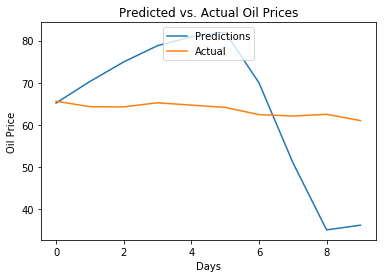

In [62]:
predictons, =plt.plot(ynewpd, label='Predictions')
actual, =plt.plot(actualpd, label='Actual')
plt.xlabel('Days')
plt.ylabel('Oil Price')
plt.title("Predicted vs. Actual Oil Prices")
plt.legend(loc = 'upper center')
plt.show()